In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
from src import algo
import numpy as np

In [34]:
lines = algo.load_data(8)
N, M, H, b, tin, tax, sec = algo.parse_data(lines)

In [35]:
tb0, ts0, tf0 = algo.first_assignment(index=0)

NameError: name 'M' is not defined

In [23]:
def dissimilarity(tb_1, ts_1, tb_2, ts_2):
    global M, H
    
    #test shifting the array first
    
    dis1 = [abs(tb_1[i+1] - tb_2[i]) for i in range(M - 1)]
    dis2 = [abs(ts_1[i+1] - ts_2[i]) for i in range(H - 1)]

    sum1 = sum(dis1)
    sum2 = sum(dis2)

    return sum1 +  sum2


In [24]:
def above_min(tb_2, ts_2, tf_2, index):
    global M, H, tin
    
    _T = compute_T_ind(tb_2, ts_2, tf_2)
    
    return sum(abs(_T - tin[index]))
    

In [25]:
def compute_T_ind(tb_1, ts_1, tf_1):
    
    global N, M
    
    T = np.zeros(shape=(M))
    

    for j in range(M):
        if j == M - 1:
            T[j] = tf_1 - tb_1[j]
        elif j+1 in b:
            T[j] = ts_1[b.index(j+1)] - tb_1[j]
        else:
            T[j] = tb_1[j+1] - tb_1[j]
            
    return T

In [22]:
from random import randint

In [26]:
def get_all(first):
    global order
    #first = randint(0, N)
    
    tb1, ts1, tf1 = first_assignment(first)

    tb = [None for i in range(N)]
    ts = [None for i in range(N)]
    tf = [None for i in range(N)]

    tb_aux, ts_aux, tf_aux = [], [], []

    tb[first], ts[first], tf[first] = tb1.copy(), ts1.copy(), tf1.copy()

    #alterar valor inicial aqui e em first_assignment
    unused_requests = set(range(N)) - {first}

    order = [first]
    
    while len(unused_requests) > 0:
        ds = []
        ds_opt = 100000000
        
        for i in unused_requests:
            tb2, ts2, tf2 = assign_new_request(tb1, ts1, tf1, i, True)
            
            #ds.append(dissimilarity(tb1, ts1, tb2, ts2))
            #ds.append(tf2)
            #ds.append(above_min(tb2, ts2, tf2, i))
            ds.append(dissimilarity_2(tb1, ts1, tb2, ts2, tf1, tf2))
            
            if ds[-1] < ds_opt:
                ds_opt = ds[-1].copy()
                tb_opt, ts_opt, tf_opt = tb2.copy(), ts2.copy(), tf2.copy()
                i_add = i
        
        [assign_new_request(tb1, ts1, tf1, i, True) for i in unused_requests]
        
        unused_requests -= {i_add}

        order.append(i_add)
        tb[i_add] = tb_opt.copy()
        ts[i_add] = ts_opt.copy()
        tf[i_add] = tf_opt.copy()

        #try it without the copy method
        tb1, ts1, tf1 = tb_opt.copy(), ts_opt.copy(), tf_opt.copy()
        
    
    return tb, ts, tf


In [205]:
%timeit -n 5 get_all(0)

477 ms ± 15.3 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [215]:
%%timeit

first=0

tb = [None for _ in range(N)]
ts = [None for _ in range(N)]
tf = [None for _ in range(N)]

tb[first], ts[first], tf[first] = first_assignment(first)

unused_requests = set(range(N)) - {first}

i_add=first

while len(unused_requests) > 0:
    dict1 = {i: diss(tb[i_add], ts[i_add], assign_new_request(tb[i_add], ts[i_add], tf[i_add], i, True)) for i in unused_requests}
    
    i_prev = i_add

    i_add = min(dict1, key=dict1.get)

    unused_requests -= {i_add}
    
    tb[i_add], ts[i_add], tf[i_add] = assign_new_request(tb[i_prev], ts[i_prev], tf[i_prev], i_add, True)
    

520 ms ± 37.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
def diss(tb_1, ts_1, t_2):
    global M, H
    
    tb_2 = t_2[0]
    ts_2 = t_2[1]
    
    dis1 = [abs(tb_1[i+1] - tb_2[i]) for i in range(M - 1)]
    dis2 = [abs(ts_1[i+1] - ts_2[i]) for i in range(H - 1)]

    sum1 = sum(dis1)
    sum2 = sum(dis2)
    
    return sum1 + sum2

In [36]:
best = 100000
start = time.time()
ti = []
fo = []
for i in range(N):
    tb, ts, tf = get_all(i)
    if max(tf) < best:
        best = max(tf).copy()
        clock = time.time()
        ti.append(clock - start)
        fo.append(best)
        print(ti[-1], fo[-1])
    
    

1.1725645065307617 6144.0
2.266629695892334 5758.0
8.594856023788452 5661.0
10.814357042312622 5564.0
53.579848766326904 5506.0


In [39]:
write_output(tb, ts, tf, fo, ti)

TypeError: write() argument must be str, not int

In [61]:
%time get_all(3); 0

Wall time: 301 ms


In [23]:
def string_line(tb, ts, tf):
    return "*".join(map(str,map(int, tb))) + "*" + "*".join(map(str,map(int, ts))) + "*" + str(int(tf))

In [24]:
def overlaps(a, b):
    """
    Return the amount of overlap, in bp
    between a and b.
    If >0, the number of bp of overlap
    If 0,  they are book-ended.
    If <0, the distance in bp between them
    """

    return min(a[1], b[1]) - max(a[0], b[0])


In [27]:
def compute_Vb(tb, ts, tf):
    aux = [(tb[j], tb[j+1] - tb[j]) if j + 1 not in b else (tb[j], ts[b.index(j + 1)] - tb[j]) for j in range(len(tb) - 1)]
    add = sum(aux[-1])
    aux.append((add, tf - add))
    return aux

In [28]:
import matplotlib.pyplot as plt

In [29]:
co = ['lightcoral', 'yellow', 'plum', 'grey', 'royalblue', 'maroon', 'coral', 'g', 'red', 'sienna']
co2 = ['yellow', 'plum', 'grey', 'royalblue', 'maroon', 'coral', 'g', 'red', 'sienna']

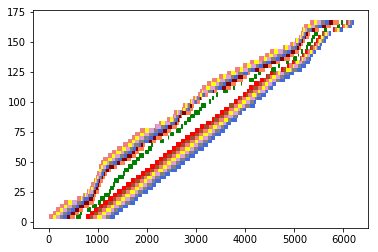

In [85]:
fig, ax = plt.subplots()
pp=0
for i in order:
    pp += 3
    ax.broken_barh(compute_Vb(tb[i], ts[i], tf[i]), yrange=(pp,3), color=co)

# ax.broken_barh(compute_Vb(tb[16], ts[16], tf[16]), yrange=(3, 20), alpha=0.5, color=)

In [36]:
order

[16,
 7,
 3,
 10,
 4,
 5,
 12,
 21,
 0,
 20,
 18,
 24,
 2,
 27,
 22,
 6,
 26,
 23,
 13,
 25,
 14,
 9,
 19,
 8,
 15,
 11,
 17,
 1]

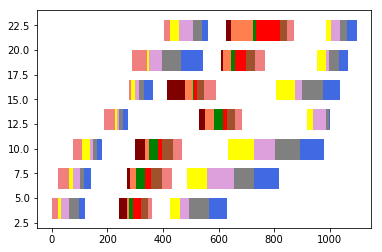

In [191]:
fig, ax = plt.subplots()
pp=0
for i in order[:7]:
    pp += 3
    ax.broken_barh(compute_Vb(tb[i], ts[i], tf[i]), yrange=(pp,2), color=co)



In [138]:
tb[4][5:]

array([414., 480., 507., 512., 521., 546., 808., 875., 901., 974.])

In [156]:
def compute_tacum(tb, ts, tf, order, req_index):
    
    for i in order:
        if i != req_index:
            compute_T_ind(tb[i], ts[i], tf[i])
            
    
    

In [180]:
tb_mat = np.matrix(tb)

In [190]:
tb_mat[order[:3],5]

matrix([[242.],
        [269.],
        [299.]])

In [172]:
int(max(tb_mat[:,0]))

404

In [154]:
compute_T_ind(tb[0], ts[0], tf[0])

array([11., 40., 27.,  5., 31., 60., 74., 99., 83., 68., 71., 24., 26.,
       14., 34.])

In [155]:
tb[0]

array([ 507.,  518.,  558.,  585.,  590.,  735.,  795.,  869.,  968.,
       1051., 1119., 1247., 1271., 1297., 1311.])

In [153]:
compute_Vb(tb[0], ts[0], tf[0])

[(507.0, 11.0),
 (518.0, 40.0),
 (558.0, 27.0),
 (585.0, 5.0),
 (590.0, 31.0),
 (735.0, 60.0),
 (795.0, 74.0),
 (869.0, 99.0),
 (968.0, 83.0),
 (1051.0, 68.0),
 (1119.0, 71.0),
 (1247.0, 24.0),
 (1271.0, 26.0),
 (1297.0, 14.0),
 (1311.0, 34.0)]

In [143]:
#como trocar
temp = tb[4][5:].copy()
tb[4][5:] = tb[10][5:].copy()
tb[10][5:] = temp.copy()

temp = ts[4][1].copy()
ts[4][1] = ts[10][1].copy()
ts[10][1] = temp.copy()

In [150]:
tb[4][5] - ts[4][0] - sec[4][0]
# se negativo deve se adiar, não recuar -> verificar se há confronto?

tb[4][5] - tb[3][5] # não se pode verificar só com o pedido anterior porque podem ter existido trocas

115.0

In [30]:
def dissimilarity_2(tb_1, ts_1, tb_2, ts_2, tf_1, tf_2):
    global M, H
    
    #test shifting the array first
    # fim de j com o início de j+1
    # pode ser visto como procurar o pedido a adicionar que tem a maior utilização?
    
    _v1 = compute_Vb(tb_1, ts_1, tf_1)
    _v2 = compute_Vb(tb_2, ts_2, tf_2)
    
    _dis = [abs(sum(req_1) - req_2[0]) for req_1, req_2 in zip(_v1[:M], _v2[1:])]
    
    return sum(_dis)

In [30]:
dissimilarity_2(tb[0], ts[0], tb[1], ts[1], tf[0], tf[1])

NameError: name 'tb' is not defined

In [31]:
def evaluate_solution(tb, ts):
    global N, M, H, tin, tax, b, sec
    
    # Bath time constraints
    
    

In [32]:
def a_solution():
    global N, M, H, tin, tax, b, sec
    
    tb

In [37]:
tb6, ts6, tf6 = get_all(12)

In [38]:
max(tf6)

2271.0

In [39]:
get_output(tb6, ts6, tf6)

567*662*747*844*1046*1086*1124*1223*1295*1361*1419*906*1468
75*103*136*150*327*420*508*574*645*732*820*174*903
35*64*103*130*282*327*420*469*499*567*620*150*637
103*138*155*174*420*508*591*668*736*823*913*195*1009
1762*1840*1850*1900*2011*2033*2061*2097*2117*2144*2149*1916*2167
372*407*459*552*815*914*945*1029*1124*1222*1290*647*1314
834*916*1005*1040*1221*1286*1312*1407*1436*1501*1555*1081*1652
1214*1309*1402*1479*1669*1741*1801*1810*1901*1936*1980*1550*2034
143*155*191*221*508*591*686*769*853*923*1009*257*1072
1016*1099*1194*1287*1483*1515*1545*1641*1725*1816*1881*1364*1980
1529*1612*1681*1709*1915*1924*1933*1968*2007*2034*2050*1806*2088
916*1009*1092*1172*1303*1327*1412*1442*1538*1629*1715*1251*1785
0*7*35*40*154*249*254*271*320*386*466*51*477
7*35*46*52*249*281*289*351*420*466*566*68*619
421*511*599*691*928*945*1030*1124*1223*1290*1342*762*1399
191*271*346*429*686*785*884*945*1029*1124*1222*522*1290
1727*1762*1806*1842*1984*2011*2033*2042*2077*2096*2122*1875*2130
1709*1724*1755*180